# NEURAL NETWORKS AND DEEP LEARNING

---
A.A. 2021/22 (6 CFU) - Dr. Alberto Testolin, Dr. Umberto Michieli
---


# Homework 1 - Supervised Deep Learning

## General overview
In this homework you will learn how to implement and test simple neural network models for solving supervised problems. It is divided in two tasks.

* **Regression task**: 
the regression model will consist in a simple function approximation problem, similar to the one discussed during the Lab practices. 

* **Classification task**: 
the classification model will consist in a simple image recognition problem, where the goal is to correctly classify images of Zalando's article images (Fashion MNIST). 

In both cases, but especially for the classification problem, you should explore the use of advanced optimizers and regularization methods (e.g., initialization scheme, momentum, ADAM, early stopping, L2, L1 / sparsity, dropout…) to improve convergence of stochastic gradient descent and promote generalization. Learning hyperparameters should be tuned using appropriate search procedures, and final accuracy should be evaluated using a cross-validation setup. For the image classification task, you can also implement more advanced convolutional architectures and explore feature visualization techniques to better understand how the deep network is encoding information at different processing layers.



## Technical notes
The homework should be implemented in Python using the PyTorch framework. The student can explore additional libraries and tools to implement the models; however, please make sure you understand the code you are writing because during the exam you might receive specific questions related to your implementation. The entire source code required to run the homework must be uploaded as a compressed archive in a Moodle section dedicated to the homework.If your code will be entirely included in a single Python notebook, just upload the notebook file.




## Final report
Along with the source code, you must separately upload a PDF file containing a brief report of your homework. The report should include a brief Introduction on which you explain the homework goals and the main implementation strategies you choose, a brief Method section where you describe your model architectures and hyperparameters, and a Result section where you present the simulation results. Total length should not exceed 6 pages, though you can include additional tables and figures in a final Appendix (optional). The report must be self-contained, so please make sure that all relevant results are explicitly included in the report / notebook.




## Grade
The maximum grade for this homework will be **8 points**. Points will be assigned based on the correct implementation of the following items:
*	2 pt: implement basic regression and classification tasks
*	2 pt: explore advanced optimizers and regularization methods (both tasks)
*	1 pt: optimize hyperparameters using grid/random search and cross-validation (both tasks)
*	2 pt: implement CNN for classification task
*	1 pt: visualize weight histograms, activation profiles and receptive fields



## Deadline
The complete homework (notebook or source code + report) must be submitted through Moodle at least 10 days before the chosen exam date.


# Regression task

## Guidelines

* The goal is to train a neural network to approximate an unknown function:
$$ 
f:\mathbb{R}→\mathbb{R} \\
x↦y=f(x) \\
\text{network}(x) \approx f(x)
$$
* As training point, you only have noisy measures from the target function.
$$
\hat{y} = f(x) + noise
$$
* Consider to create a validation set from you training data, or use a k-fold cross-validation strategy. You may find useful these functions from the `scikit-learn` library:
    - [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)
    - [KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold) 

## Dataset

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn. preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

The following cell of code will download the dataset and make it available in the local folder `regression_dataset`. There are two files:

* `regression_dataset/train_data.csv`
* `regression_dataset/test_data.csv`

Use them to train and test your model. Each row contains two values, respactively the input and the target (label).

In [30]:
!wget -P regression_dataset https://gitlab.dei.unipd.it/michieli/nnld-2021-22-lab-resources/-/raw/main/homework1/train_data.csv
!wget -P regression_dataset https://gitlab.dei.unipd.it/michieli/nnld-2021-22-lab-resources/-/raw/main/homework1/test_data.csv 

--2022-01-16 20:55:03--  https://gitlab.dei.unipd.it/michieli/nnld-2021-22-lab-resources/-/raw/main/homework1/train_data.csv
正在解析主机 gitlab.dei.unipd.it (gitlab.dei.unipd.it)... 147.162.2.85
正在连接 gitlab.dei.unipd.it (gitlab.dei.unipd.it)|147.162.2.85|:443... 已连接。
已发出 HTTP 请求，正在等待回应... 200 OK
长度：3776 (3.7K) [text/plain]
正在保存至: “regression_dataset/train_data.csv.28”

train_data.csv.28   100%[===================>]   3.69K  --.-KB/s  用时 0s        

2022-01-16 20:55:03 (18.6 MB/s) - 已保存 “regression_dataset/train_data.csv.28” [3776/3776])

--2022-01-16 20:55:03--  https://gitlab.dei.unipd.it/michieli/nnld-2021-22-lab-resources/-/raw/main/homework1/test_data.csv
正在解析主机 gitlab.dei.unipd.it (gitlab.dei.unipd.it)... 147.162.2.85
正在连接 gitlab.dei.unipd.it (gitlab.dei.unipd.it)|147.162.2.85|:443... 已连接。
已发出 HTTP 请求，正在等待回应... 200 OK
长度：3788 (3.7K) [text/plain]
正在保存至: “regression_dataset/test_data.csv.28”

test_data.csv.28    100%[===================>]   3.70K  --.-KB/s  用时 0s        

2022-01-16 20:5

How to load the data:

In [31]:
train_df = pd.read_csv('regression_dataset/train_data.csv')
train_df = train_df.sort_values('input')
x_train = train_df.iloc[:,0].values
y_train = train_df.iloc[:,1].values
print("x_train: ",x_train)
print("y_train: ",y_train)
#print("x_train shape",x_train.shape)
#print("y_train shape",y_train.shape)
x_train = np.reshape(x_train,(1, x_train.size))
print("x_train shape",x_train.shape)
y_train = np.reshape(y_train,(1, y_train.size))


x_train:  [-4.91586284 -4.78787019 -4.75410728 -4.71965718 -4.71648826 -4.4797566
 -4.45202139 -4.43685421 -4.23058819 -4.22085193 -4.20904998 -4.19002703
 -4.08351763 -4.0648022  -3.94695751 -3.88896465 -3.85537293 -3.84450729
 -3.80181167 -3.76878898 -3.75473317 -3.66407518 -3.54400746 -3.50905703
 -3.44016059 -3.19453581 -3.12286175 -3.08224242 -3.05002328 -3.03113639
 -0.93957081 -0.93309933 -0.90292075 -0.8025681  -0.76904388 -0.75425133
 -0.65387273 -0.60971738 -0.48598514 -0.46424157 -0.33884202 -0.33630048
 -0.3298803  -0.30924234 -0.2649473  -0.25311031 -0.22212626 -0.1704728
 -0.1086442  -0.06637551  0.14180836  0.31874401  0.3635325   0.8119635
  0.90285791  1.29945941  1.45830856  1.53942648  1.59770317  1.72599515
  3.10549054  3.13026067  3.24532891  3.24545168  3.4972157   3.65874366
  3.67975852  3.72643234  3.76692173  3.83795581  4.0233863   4.0380728
  4.06681054  4.10003748  4.14387614  4.14389831  4.26876842  4.36860029
  4.39123483  4.45452347  4.49999879  4.54724

How to get a specific sample:

In [32]:
sample_index = 0
input = train_df.iloc[sample_index]['input']
label = train_df.iloc[sample_index]['label']

print(f"SAMPLE AT INDEX {sample_index}")
print(f"INPUT: {input}")
print(f"LABEL: {label}")

SAMPLE AT INDEX 0
INPUT: -4.915862840819678
LABEL: -3.742969516141261


All training points:

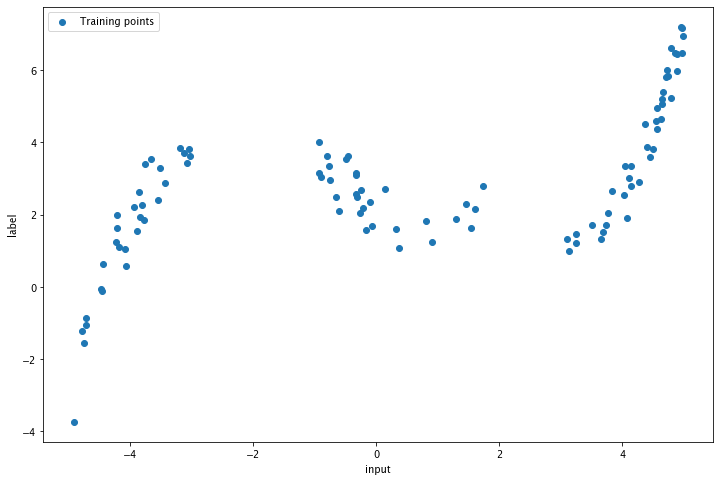

In [33]:
fig = plt.figure(figsize=(12,8))
plt.scatter(train_df.input, train_df.label, label='Training points')
plt.xlabel('input')
plt.ylabel('label')
plt.legend()
plt.show()

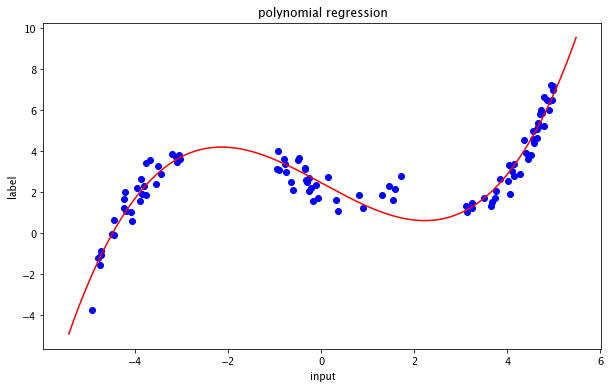

In [34]:
def apply_polynomial_regression(x,y,degree=3):
    poly_reg = PolynomialFeatures(degree=degree)
    x2 = x.reshape(len(x[0]),1)
    y2 = y.flatten()
    X_poly = poly_reg.fit_transform(x2)
    lin_reg = LinearRegression().fit(X_poly, y2)
    # Visualizing the Polymonial Regression results
    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, color='blue')
    x_generated = np.linspace(min(x2) - 0.5, max(x2) + 0.5, 1000) 
    y3 = lin_reg.predict(poly_reg.fit_transform(x_generated))
    plt.plot(x_generated, y3, color='red')
    plt.title('polynomial regression')
    plt.xlabel('input')
    plt.ylabel('label')
    plt.show()

apply_polynomial_regression(x_train,y_train)


# Network Training

## Network Definition
Define a fully connected feed-forward network with 2 hidden layers.

Use a sigmoid activation function.

In [35]:
class Net(nn.Module):
    def __init__(self, Ni, Nh1, Nh2, No):
        """
        Ni - Input size
        Nh1 - Neurons in the 1st hidden layer
        Nh2 - Neurons in the 2nd hidden layer
        No - Output size
        """
        super().__init__()
        
        print('Network initialized')
        self.fc1 = nn.Linear(in_features=Ni, out_features=Nh1)
        self.fc2 = nn.Linear(in_features=Nh1, out_features=Nh2)
        self.out = nn.Linear(in_features=Nh2, out_features=No)
        self.act = nn.Sigmoid()
        
    def forward(self, x, additional_out=False):
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        x = self.out(x)
        return x


Define the dataset

In [86]:
class CsvDataset(Dataset):

    def __init__(self, csv_file, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.transform = transform
        # Read the file and split the lines in a list
        with open(csv_file, 'r') as f:
            lines = f.read().split('\n')
        # Get x and y values from each line and append to self.data
        self.data = []
        data_len = len(lines)
        for i in range(1,data_len-1):
            sample = lines[i].split(',')
            try:
                self.data.append((float(sample[0]), float(sample[1])))
        # Now self.data contains all our dataset.
        # Each element of the list self.data is a tuple: (input, output)
            except ValueError :
                print("error on line",i)
                break


    def __len__(self):
        # The length of the dataset is simply the length of the self.data list
        return len(self.data)

    def __getitem__(self, idx):
        # Our sample is the element idx of the list self.data
        sample = self.data[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample

Define the transformations

In [87]:
class ToTensor(object):
    """Convert sample to Tensors."""

    def __call__(self, sample):
        x, y = sample
        return (torch.tensor([x]).float(),
                torch.tensor([y]).float())

In [88]:
composed_transform = transforms.Compose([ToTensor()])

train_dataset = CsvDataset('regression_dataset/train_data.csv', transform=composed_transform)
test_dataset = CsvDataset('regression_dataset/test_data.csv', transform=composed_transform)

### dataloader
For the dataloader:

* enable the shuffling only for training data
* try different values for batch size
* disable the multiprocessing 

In [89]:
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
test_dataloader  = DataLoader(test_dataset,  batch_size=len(test_dataset), shuffle=False, num_workers=0)

## Training loop

In [90]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

Training device: cpu


In [91]:
# Initialize the network
torch.manual_seed(0)
Ni = 1
Nh1 = 128
Nh2 = 256
No = 1
net = Net(Ni, Nh1, Nh2, No)
net.to(device)

Network initialized


Net(
  (fc1): Linear(in_features=1, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=1, bias=True)
  (act): Sigmoid()
)

In [92]:
# Define the loss function
loss_fn = nn.MSELoss()

In [93]:
# Define the optimizer
optimizer = optim.Adam(net.parameters(), lr=1e-3)

In [95]:
### TRAINING LOOP
num_epochs = 3000
train_loss_log = []
test_loss_log = []
for epoch_num in range(num_epochs):
    print('#################')
    print(f'# EPOCH {epoch_num}')
    print('#################')

    ### TRAIN
    train_loss= []
    net.train() # Training mode (e.g. enable dropout, batchnorm updates,...)
    for sample_batched in train_dataloader:
        # Move data to device
        x_batch = sample_batched[0].to(device)
        label_batch = sample_batched[1].to(device)

        # Forward pass
        out = net(x_batch)

        # Compute loss
        loss = loss_fn(out, label_batch)

        # Backpropagation
        net.zero_grad()
        loss.backward()

        # Update the weights
        optimizer.step()

        # Save train loss for this batch
        loss_batch = loss.detach().cpu().numpy()
        train_loss.append(loss_batch)

    # Save average train loss
    train_loss = np.mean(train_loss)
    print(f"AVERAGE TRAIN LOSS: {train_loss}")
    train_loss_log.append(train_loss)

    ### VALIDATION
    test_loss= []
    net.eval() # Evaluation mode (e.g. disable dropout, batchnorm,...)
    with torch.no_grad(): # Disable gradient tracking
        for sample_batched in test_dataloader:
            # Move data to device
            x_batch = sample_batched[0].to(device)
            label_batch = sample_batched[1].to(device)

            # Forward pass
            out = net(x_batch)

            # Compute loss
            loss = loss_fn(out, label_batch)

            # Save val loss for this batch
            loss_batch = loss.detach().cpu().numpy()
            test_loss.append(loss_batch)

        # Save average validation loss
        test_loss = np.mean(test_loss)
        print(f"AVERAGE VAL LOSS: {np.mean(test_loss)}")
        test_loss_log.append(test_loss)
    

#################
# EPOCH 0
#################
AVERAGE TRAIN LOSS: 2.819979190826416
AVERAGE VAL LOSS: 2.843344211578369
#################
# EPOCH 1
#################
AVERAGE TRAIN LOSS: 2.636139154434204
AVERAGE VAL LOSS: 2.94181489944458
#################
# EPOCH 2
#################
AVERAGE TRAIN LOSS: 2.7298548221588135
AVERAGE VAL LOSS: 3.043100357055664
#################
# EPOCH 3
#################
AVERAGE TRAIN LOSS: 2.663914203643799
AVERAGE VAL LOSS: 2.9221081733703613
#################
# EPOCH 4
#################
AVERAGE TRAIN LOSS: 2.669381618499756
AVERAGE VAL LOSS: 2.862778902053833
#################
# EPOCH 5
#################
AVERAGE TRAIN LOSS: 2.6570284366607666
AVERAGE VAL LOSS: 2.933281660079956
#################
# EPOCH 6
#################
AVERAGE TRAIN LOSS: 2.6507561206817627
AVERAGE VAL LOSS: 2.8703458309173584
#################
# EPOCH 7
#################
AVERAGE TRAIN LOSS: 2.661008834838867
AVERAGE VAL LOSS: 2.960939884185791
#################
# EPOCH 8
########

## Plot losses

In [96]:
# Plot losses
plt.figure(figsize=(12,8))
plt.semilogy(train_loss_log, label='Train loss')
plt.semilogy(test_loss_log, label='Test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

findfont: Font family ['DejaVu Sans'] not found. Falling back to DejaVu Sans.


ValueError: Failed to find font DejaVu Sans:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0, and fallback to the default font was disabled

<Figure size 864x576 with 1 Axes>

# Classification task

## Guidelines

* The goal is to train a neural network that maps an input image (from fashionMNIST) to one of ten classes (multi-class classification problem with mutually exclusive classes).
* Define a proper loss (e.g. [torch.nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss))
* Also here, consider to create a validation set from you training data, or use a k-fold cross-validation strategy.
* Pay attention to the shape, data type and output values range. If needed, modify them accordingly to your implementation (read carefully the documentation of the layers that you use, e.g. [torch.nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)).
* Explore different optimizers, acivation functions, network architectures. Analyze the effect of different regularization methods, such as dropout layers, random transformations (image rotation, scaling, add noise...) or L2 regularization (weight decay).

## Dataset

In [ ]:
import torch
from pathlib import Path
import pandas as pd
import numpy as np
import random
import torchvision
import matplotlib.pyplot as plt
import torchvision.datasets as dsts
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold

import torch.nn.functional as F
import torch.nn as NN
torch.__version__



'1.10.0'

In order to use dataloader from pyTorch, we need to build a dataset

In [ ]:
# class FashionMNISTDataset(Dataset):
#     def __init__(self, csv_file, transform=None):
#         data = pd.read_csv(csv_file)
#         self.X = np.array(data.iloc[:, 1:]).reshape(-1, 1, 28, 28).astype(float)
#         self.Y = np.array(data.iloc[:, 0]);
#         del data;  #结束data对数据的引用,节省空间
#         self.len=len(self.X)

#     def __len__(self):
#         return self.len
#         #return len(self.X)


#     def __getitem__(self, idx):
#         item = self.X[idx]
#         label = self.Y[idx]
#         return (item, label)

Download the dataset:

In [ ]:
train_dataset = torchvision.datasets.FashionMNIST('classifier_data', train=True, download=True)
test_dataset  = torchvision.datasets.FashionMNIST('classifier_data', train=False, download=True)

100.0%


Extracting classifier_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to classifier_data/FashionMNIST/raw

Using downloaded and verified file: classifier_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz
Extracting classifier_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to classifier_data/FashionMNIST/raw



100.0%


Extracting classifier_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to classifier_data/FashionMNIST/raw

Using downloaded and verified file: classifier_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz
Extracting classifier_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to classifier_data/FashionMNIST/raw



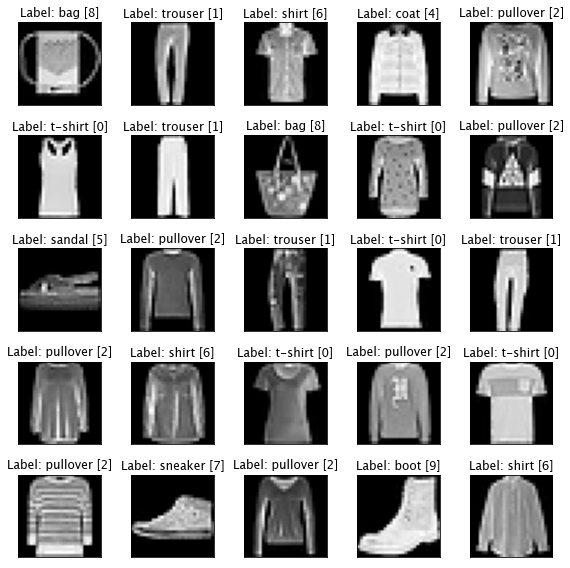

In [ ]:
### Plot some sample
label_names=['t-shirt','trouser','pullover','dress','coat','sandal','shirt',
             'sneaker','bag','boot']
fig, axs = plt.subplots(5, 5, figsize=(8,8))
for ax in axs.flatten():
    # random.choice allows to randomly sample from a list-like object (basically anything that can be accessed with an index, like our dataset)
    img, label = random.choice(train_dataset)
    ax.imshow(np.array(img), cmap='gist_gray')
    ax.set_title(f'Label: {label_names[label]} [{label}]')
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

How to get an image and the corresponding label:

SAMPLE AT INDEX 1
LABEL: 0


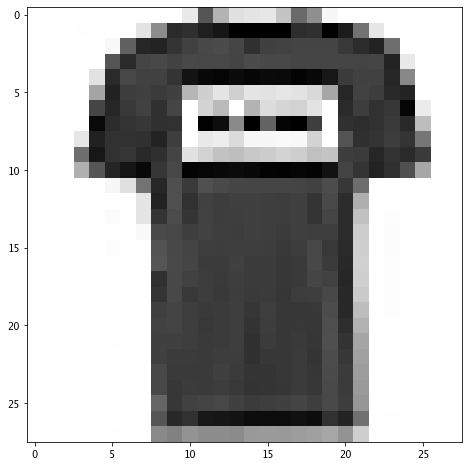

In [ ]:
sample_index = 1
image = train_dataset[sample_index][0]
label = train_dataset[sample_index][1]

fig = plt.figure(figsize=(8,8))
plt.imshow(image, cmap='Greys')
print(f"SAMPLE AT INDEX {sample_index}")
print(f"LABEL: {label}")

The output of the dataset is a PIL Image, a python object specifically developed to manage and process images. PyTorch supports this format, and there are useful transforms available natively in the framework: https://pytorch.org/docs/stable/torchvision/transforms.html

If you want, you can easily convert a PIL image to a numpy array and entirely ignore the PIL object:

In [ ]:

image_numpy = np.array(image)

print(f'Numpy array shape: {image_numpy.shape}')
print(f'Numpy array type: {image_numpy.dtype}')

Numpy array shape: (28, 28)
Numpy array type: uint8


To transform a PIL Image directly to a PyTorch tensor, instead:

In [ ]:

to_tensor = torchvision.transforms.ToTensor()
image_tensor = to_tensor(image)

print(f'PyTorch tensor shape: {image_tensor.shape}')
print(f'PyTorch tensor type: {image_tensor.dtype}')

PyTorch tensor shape: torch.Size([1, 28, 28])
PyTorch tensor type: torch.float32


目标：
implement classification tasks and explore advanced optimizers and regularization methods
*	1 pt: optimize hyperparameters using grid/random search and cross-validation 
*	2 pt: implement CNN for classification task
*	1 pt: visualize weight histograms, activation profiles and receptive fields

## Define the dataset transform

In [ ]:

train_transform = transforms.Compose([
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
])

# Set the train transform
train_dataset.transform = train_transform

# Set the test transform
test_dataset.transform = test_transform

## Define the dataloader

train: 60000 test: 10000
train: 50000 validation 10000 test: 10000


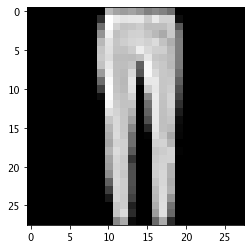

In [ ]:
print('train:', len(train_dataset), 'test:', len(test_dataset))
# 首先先查看train和test数据集的数量，看看是否满足预订的分配目标

train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [50000, 10000])

print('train:', len(train_dataset), 'validation',len(val_dataset),'test:', len(test_dataset))

#define a batch size as 256
BATCH_SIZE = 256

#load the data to use them
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,batch_size = BATCH_SIZE,shuffle = True)
val_loader = torch.utils.data.DataLoader(dataset = val_dataset,batch_size = BATCH_SIZE,shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,batch_size = BATCH_SIZE,shuffle = False) 
# needn't shuffle for test data



#have a look on the data
a = iter(train_loader)
data = next(a)

img = data[0][0].reshape(28,28)
data[0][0].shape,img.shape
(torch.Size([1, 28, 28]), torch.Size([28, 28]))
plt.imshow(img,cmap = plt.cm.gray)
plt.show()


## Build Neural Networks

In [ ]:
class CNN(NN.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = NN.Sequential(   
            NN.Conv2d(1, 16, kernel_size=5, padding=2),
            NN.BatchNorm2d(16), 
            NN.ReLU()) #16, 28, 28
        self.pool1=NN.MaxPool2d(2) #16, 14, 14
        self.layer2 = NN.Sequential(
            NN.Conv2d(16, 32, kernel_size=3),
            NN.BatchNorm2d(32),
            NN.ReLU())#32, 12, 12
        self.layer3 = NN.Sequential(
            NN.Conv2d(32, 64, kernel_size=3),
            NN.BatchNorm2d(64),
            NN.ReLU()) #64, 10, 10
        self.pool2=NN.MaxPool2d(2)  #64, 5, 5
        self.fc = NN.Linear(5*5*64, 10)
    def forward(self, x):
        out = self.layer1(x)
        #print(out.shape)
        out=self.pool1(out)
        #print(out.shape)
        out = self.layer2(out)
        #print(out.shape)
        out=self.layer3(out)
        #print(out.shape)
        out=self.pool2(out)
        #print(out.shape)
        out = out.view(out.size(0), -1)
        #print(out.shape)
        out = self.fc(out)
        return out




In [ ]:

cnn = CNN()
#可以通过以下方式验证，没报错说明没问题，
cnn(torch.rand(1,1,28,28))

tensor([[ 0.3646, -0.8356,  0.6921,  0.8806, -0.2247, -0.7940,  0.3123, -0.6528,
          0.0469, -0.9888]], grad_fn=<AddmmBackward0>)

In [ ]:
print(cnn)

CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=1600, out_features=10, bias=True)
)


In [ ]:
DEVICE=torch.device("cpu")
if torch.cuda.is_available():
        DEVICE=torch.device("cuda")
print(DEVICE)

cpu


In [ ]:
cnn=cnn.to(DEVICE)

## Loss Function


In [ ]:
criterion = NN.CrossEntropyLoss().to(DEVICE)

## Optimizer

In [ ]:
LEARNING_RATE=0.01
optimizer = torch.optim.Adam(cnn.parameters(), lr=LEARNING_RATE)

## Training

In [ ]:
TOTAL_EPOCHS=50
losses = []
for epoch in range(TOTAL_EPOCHS):
    for i, (images, labels) in enumerate(train_loader):
        images = images.float().to(DEVICE)
        labels = labels.to(DEVICE)
        #清零
        optimizer.zero_grad()
        outputs = cnn(images)
        #计算损失函数
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        losses.append(loss.cpu().data.item());
        if (i+1) % 100 == 0:
            print ('Epoch : %d/%d, Iter : %d/%d,  Loss: %.4f'%(epoch+1, TOTAL_EPOCHS, i+1, len(train_dataset)//BATCH_SIZE, loss.data.item()))


Epoch : 1/50, Iter : 100/195,  Loss: 0.3318
Epoch : 2/50, Iter : 100/195,  Loss: 0.3720
Epoch : 3/50, Iter : 100/195,  Loss: 0.2526
Epoch : 4/50, Iter : 100/195,  Loss: 0.2384
Epoch : 5/50, Iter : 100/195,  Loss: 0.2322
Epoch : 6/50, Iter : 100/195,  Loss: 0.2062
Epoch : 7/50, Iter : 100/195,  Loss: 0.2037
Epoch : 8/50, Iter : 100/195,  Loss: 0.2105
Epoch : 9/50, Iter : 100/195,  Loss: 0.2205
Epoch : 10/50, Iter : 100/195,  Loss: 0.1348
Epoch : 11/50, Iter : 100/195,  Loss: 0.2036
Epoch : 12/50, Iter : 100/195,  Loss: 0.1310
Epoch : 13/50, Iter : 100/195,  Loss: 0.1201
Epoch : 14/50, Iter : 100/195,  Loss: 0.1813
Epoch : 15/50, Iter : 100/195,  Loss: 0.1410
Epoch : 16/50, Iter : 100/195,  Loss: 0.1224
Epoch : 17/50, Iter : 100/195,  Loss: 0.1029
Epoch : 18/50, Iter : 100/195,  Loss: 0.0813
Epoch : 19/50, Iter : 100/195,  Loss: 0.1624
Epoch : 20/50, Iter : 100/195,  Loss: 0.0681
Epoch : 21/50, Iter : 100/195,  Loss: 0.0625
Epoch : 22/50, Iter : 100/195,  Loss: 0.1670
Epoch : 23/50, Iter

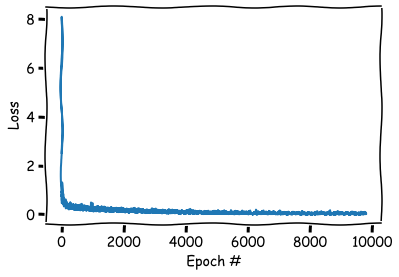

In [ ]:
plt.xkcd();
plt.xlabel('Epoch #');
plt.ylabel('Loss');
plt.plot(losses);
plt.show();

In [ ]:
torch.save(cnn.state_dict(), "fm-cnn3.pth")
# 加载用
#cnn.load_state_dict(torch.load("fm-cnn3.pth"))

### Validation accuracy


In [ ]:
cnn.eval()
correct = 0
total = 0
for images, labels in val_loader:
    images = images.float().to(DEVICE)
    outputs = cnn(images).cpu()
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()
print('accuracy: %.4f %%' % (100 * correct / total))

accuracy: 88.0400 %


### Test accuracy

In [ ]:
cnn.eval()
correct = 0
total = 0
for images, labels in test_loader:
    images = images.float().to(DEVICE)
    outputs = cnn(images).cpu()
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()
print('accuracy: %.4f %%' % (100 * correct / total))

accuracy: 87.4300 %
